<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#загрузим все необходимые библиотеки и инструменты
import re
import time
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize  
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Загрузим данные и ознакомимся с ними.

In [2]:
comments = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [4]:
# удалим ошибочный столбец "Unnamed: 0" 
del comments['Unnamed: 0'] 

In [5]:
display(comments.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Наши данные состоят из двух столбцов. Столбец 'text' содержит текст комментария, а столбец 'toxic' - целевой признак

Посмотрим на распределение целевого признака

In [6]:
comments['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

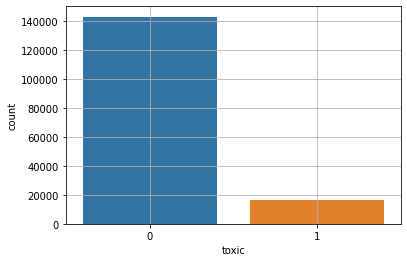

In [7]:
sns.countplot(data=comments, x='toxic')
plt.title('')
plt.grid()

Наблюдаем явный дисбаланс классов, токсичных комментариев существенно меньше, чем позитивных или нейтральных.

Посмотрим какие слова встречаются чаще всего

In [8]:
print(pd.Series(' '.join(comments.text).split(' ')).value_counts())

the                     444416
to                      287844
                        226292
of                      218673
and                     206130
                         ...  
deletion/Armageddon          1
\n\nMUSICOR\n\nDEBUT         1
ध्वनि                        1
Møn.                         1
mailling                     1
Length: 606410, dtype: int64


Как видим чаще всего встречаются так называемые стоп-слова

Найдем длину самого весомого комментария

In [9]:
for c in comments:
    if comments[c].dtype == 'object':
        print('Max length of column %s: %s\n' %  (c, comments[c].map(len).max()))

Max length of column text: 5000



Нам необходимо очистить текст от нежелательных символом и применить стемминг

In [13]:
def clear_text(text):
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z ]', ' ', text).strip()
    
    # Удаляем html теги
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Удаляем единичные символы
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Удаляем единычные символы из начала строки
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    
    # Заменяем несколько пробелов на один
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Удаляем 'b'
    text = re.sub(r'^b\s+', '', text)
        
    return text

In [14]:
comments['text'] = comments['text'].apply(clear_text)
display(comments.head())

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour m seem...,0
2,hey man m really not trying to edit war it jus...,0
3,more can make any real suggestions on improvem...,0
4,you sir are my hero any chance you remember wh...,0


In [15]:
#токкенизируем текс
comments['text'] = comments['text'].apply(lambda text: word_tokenize(text))

In [16]:
comments.head()

,text,toxic
0,"[explanation, why, the, edits, made, under, my...",0
1,"[d, aww, he, matches, this, background, colour...",0
2,"[hey, man, m, really, not, trying, to, edit, w...",0
3,"[more, can, make, any, real, suggestions, on, ...",0
4,"[you, sir, are, my, hero, any, chance, you, re...",0


С помощью стемминга приведем слова к форме основы. Воспользуемся инструментом EnglishStemmer из библиотеки nltk. Применим ко всему датасету.

In [17]:
stemmer = EnglishStemmer(ignore_stopwords=False)

In [18]:
stemm = comments['text'].apply(lambda x: ' '.join ([stemmer.stem(y) for y in x]))

In [19]:
stemm.shape

(159292,)

In [20]:
stemm.head()

0    explan whi the edit made under my usernam hard...
1    d aww he match this background colour m seem s...
2    hey man m realli not tri to edit war it just t...
3    more can make ani real suggest on improv wonde...
4    you sir are my hero ani chanc you rememb what ...
Name: text, dtype: object

Выделим целевой признак - toxic

In [21]:
y = comments['toxic']

Разделим датасет на обучающую и тестовую выборки.

In [24]:
text_train, text_test, y_train, y_test = train_test_split(stemm, y, test_size=0.3, random_state=555)

Загрузим список стоп-слов

In [27]:
stop_words = list(stopwords.words('english'))
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

## Обучение

Проверим несколько способов предварительной подготовки корпуса: с использованием мешка слов и параметра TF-IDF, с отсечением стоп-слов и без отсечения, а также с использованием только униграмм и совместно униграмм и биграмм.
Подготовим соответствующие пайпланы и произведем оценку на модели Логистической Регрессии на кросс-валидации по обучающей выборке.

In [28]:
lgr_model = LogisticRegression(class_weight='balanced')

pipeline_cnt = make_pipeline(CountVectorizer(), lgr_model)
pipeline_cnt_2 = make_pipeline(CountVectorizer(ngram_range=(1,2)), lgr_model)
pipeline_cnt_stop = make_pipeline(CountVectorizer(stop_words=stop_words), lgr_model)
pipeline_cnt_stop_2 = make_pipeline(CountVectorizer(stop_words=stop_words, ngram_range=(1,2)), lgr_model)


pipeline_tfidf = make_pipeline(TfidfVectorizer(), lgr_model)
pipeline_tfidf_2 = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), lgr_model) 
pipeline_tfidf_stop = make_pipeline(TfidfVectorizer(stop_words=stop_words), lgr_model)
pipeline_tfidf_stop_2 = make_pipeline(TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2)), lgr_model)

In [29]:
pipeline_list = [pipeline_cnt, pipeline_cnt_2, pipeline_cnt_stop, pipeline_cnt_stop_2, 
                    pipeline_tfidf, pipeline_tfidf_2, pipeline_tfidf_stop, pipeline_tfidf_stop_2]

In [30]:
for pipeline in pipeline_list:
    print(pipeline.get_params)

    start_time = time.time()
    f1 = cross_val_score(pipeline, X=text_train, y=y_train, cv=3, scoring='f1'). mean()
    end_time = time.time()
    training_time = end_time - start_time

    print(f'F1-score = {round(f1, 2)}, training_time = {round(training_time, 1)}')
    print()

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1-score = 0.76, training_time = 151.2

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1-score = 0.79, training_time = 347.6

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1-score = 0.75, training_time = 140.4

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

F1-score = 0.79, training_time = 367.6

<bound method Pipeline.get_params of Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>
F1-score = 0.74, training_time = 107.9

<bound method Pipeline.get_params of Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>
F1-score = 0.74, training_time = 244.7

<bound method Pipeline.get_params of Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
              

|Модель|	f1 score | 
| -------|:----:|
|pipeline_cnt|0.76|
|**pipeline_cnt_2**|**0.79**|
|pipeline_cnt_stop|0.75|
|**pipeline_cnt_stop_2**|**0.79**|
|pipeline_tfidf|0.74|
|pipeline_tfidf_2|0.74|
|pipeline_tfidf_stop|0.75|
|pipeline_tfidf_stop_2|0.75|

При использовании CountVectorize добавление биграмм несколько повышает качество модели, однако сильно увеличивает время расчета. Применение стоп-слов несколько ухудшает качество модели, практически не отражаясь на скорости обучения. При использовании TfidfVectorizer качество модели практически не зависит от добавления биграмм и стоп-слов. Метод CountVectorize обеспечивает более высокую метрику качества F1-score, по сравнению с TF-IDF.
Таким образом, наиболее предпочтитетельная подготовка вектора признаков в данном случае основана на использовании метода мешка слов на основе униграмм и биграмм без использования стоп-слов.

Попробуем также для выбранного метода подготовки данных, использовать модели классификации с дефолтными параметрами: Дерево Решений, k-ближайших и Логистическую Регрессию со Стохастическим Градиентным Спуском.

In [38]:
# Модель Дерева Решений

pipeline_dtf = make_pipeline(CountVectorizer(ngram_range=(1,2)), DecisionTreeClassifier(random_state=555, 
                                                                                        class_weight='balanced'))
cross_val_score(pipeline_dtf, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.59

In [39]:
# Модель k-Ближайших соседей

pipeline_knn = make_pipeline(CountVectorizer(ngram_range=(1,2)), KNeighborsClassifier())
cross_val_score(pipeline_knn, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.38

In [40]:
#Логистическая Регрессия с SGD

pipeline_sgd = make_pipeline(CountVectorizer(ngram_range=(1,2)), SGDClassifier(random_state=555, 
                                                                                        class_weight='balanced'))
cross_val_score(pipeline_sgd, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.77

|Модель |	f1 score | 
| -------|:----:|
|Дерево Решений|0.59|
|k-Ближайшие соседи|0.38|
|**Логистическая Регрессия с SGD**|**0.77**|
|**Логистическая Регрессия с cnt_stop_2,cnt_2**|**0.79**|

Качество моделей Дерево Решений и k-ближайших соседей существенно ниже. Вариант Лостической Регрессии со Стохастическим Градиентным Спуском показывает несколько меньшее значение метрики качества, однако существенно выигрывает во врмени.
Остановимся на моделях Логистической Регрессии, попробуем настроить гиперпараметры

In [42]:
log_grid = {'logisticregression__C' : np.logspace(-2, 3, 10)}
log_search = GridSearchCV(estimator=pipeline_cnt_2, 
                            param_grid = log_grid, 
                            cv=3,
                            n_jobs = -1,
                            scoring='f1')
log_search.fit(text_train, y_train)
round(log_search.best_score_, 2)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.79

In [43]:
sgd_grid = {'sgdclassifier__loss':['hinge', 'log'],
            'sgdclassifier__learning_rate':['optimal', 'adaptive'],
            'sgdclassifier__eta0':[0.05, 0.1, 0.2, 0.5]}
sgd_search = GridSearchCV(estimator=pipeline_sgd, 
                            param_grid = sgd_grid, 
                            cv=3,
                            n_jobs = -1,
                            scoring='f1')
sgd_search.fit(text_train, y_train)
round(sgd_search.best_score_, 2)

0.78

In [44]:
sgd_search.best_params_

{'sgdclassifier__eta0': 0.5,
 'sgdclassifier__learning_rate': 'adaptive',
 'sgdclassifier__loss': 'log'}

Подбор гиперпараметров несколько повысил качество модели SGD.

Обучим модели Логистической Регрессии на полном наборе обучающих данных и рассчитаем метрику f1 на тестовом наборе.

In [45]:
%%time
log_search.best_estimator_.fit(text_train, y_train)
y_pred = log_search.best_estimator_.predict(text_test)
f1_score(y_test, y_pred)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 1min 21s, sys: 51.7 s, total: 2min 12s
Wall time: 2min 13s


0.7909451283121219

In [46]:
%%time
sgd_search.best_estimator_.fit(text_train, y_train)
y_pred = sgd_search.best_estimator_.predict(text_test)
f1_score(y_test, y_pred)

CPU times: user 31.1 s, sys: 148 ms, total: 31.3 s
Wall time: 31.4 s


0.7881822734101152

Модель логистической регрессии имеет лучшую метрику f1 и может быть использована для поиска токсичных комментариев и отправки их на модерацию в Интернет-магазине «Викишоп».

## Выводы

Исходный набор текстовых данных подготовлен для задачи классификации: удалены лишние символы, произведена токенизация и стемминг текста. На модели логистической регрессии проверено несколько вариантов подготовки векторов признаков из исходного корпуса: с использованием мешка слов и TF-IDF, со стоп-словами и без, а также с разделением на униграммы и биграммы и только на униграммы. Выбран способ подготовки с использованием CountVectorizer, без стоп-слов и на основе униграмм и биграмм. Проверено несколько других методов классификации: Деревья Решений, k-ближайших соседей и Логистическая регрессия со стохастическим Градиентным Спуском. Наилучшее значение метрики качества F1 на обучающей выборке на кросс-валидации получено на Логистической Регрессии, применение метода SGD несколько снижает качество, однако дает выигрыш в скорости расчета. Выбранные модели протестированы на тестовой выборке, метрика f1 составила 0,78 - 0,79, что примерно соответствует качеству на обучающей выборке.